In [1]:
import numpy as np
from scipy import signal
from sympy import *
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
from numpy.random import randn
from filterpy.kalman import KalmanFilter
import eom2js

def disp(name: str, symbol: Symbol):
    display(Eq(Dummy(name), symbol, evaluate=False))
    print(latex(Eq(Dummy(name), symbol, evaluate=False), mode="equation*"))

def mateq2list(lhs: Matrix, rhs: Matrix):
    L = []
    for i in range(lhs.rows):
        L.append(Eq(lhs[i], rhs[i], evaluate=False))
    return L

def latexprint(expr):
    display(expr)
    return print(latex(expr, mode="equation*"))

In [2]:
m = symbols("m")
T1, T2 = symbols("T1 T2")
a = symbols("alpha")

w, h = symbols("w, h")

# Fuerzas y Torque body frame
F_bf = Matrix([
    (T1-T2)*sin(a),
    (-T1-T2)*cos(a)
])
T = (T1-T2)*(cos(a)*w/2 - sin(a)*h/2)


disp("T", T)
disp("F", F_bf)

Eq(_T, (T1 - T2)*(-h*sin(alpha)/2 + w*cos(alpha)/2))

\begin{equation*}T = \left(T_{1} - T_{2}\right) \left(- \frac{h \sin{\left(\alpha \right)}}{2} + \frac{w \cos{\left(\alpha \right)}}{2}\right)\end{equation*}


Eq(_F, Matrix([
[ (T1 - T2)*sin(alpha)],
[(-T1 - T2)*cos(alpha)]]))

\begin{equation*}F = \left[\begin{matrix}\left(T_{1} - T_{2}\right) \sin{\left(\alpha \right)}\\\left(- T_{1} - T_{2}\right) \cos{\left(\alpha \right)}\end{matrix}\right]\end{equation*}


In [3]:
theta = symbols("theta", cls=Function)
t = symbols("t")
g = symbols("g")
# Fuerzas en sistema inercial
R = Matrix([
    [cos(theta(t)), -sin(theta(t))],
    [sin(theta(t)), cos(theta(t))]
])

F = R*F_bf + Matrix([0, m*g])

disp("R", R)
disp("F", F)

Eq(_R, Matrix([
[cos(theta(t)), -sin(theta(t))],
[sin(theta(t)),  cos(theta(t))]]))

\begin{equation*}R = \left[\begin{matrix}\cos{\left(\theta{\left(t \right)} \right)} & - \sin{\left(\theta{\left(t \right)} \right)}\\\sin{\left(\theta{\left(t \right)} \right)} & \cos{\left(\theta{\left(t \right)} \right)}\end{matrix}\right]\end{equation*}


Eq(_F, Matrix([
[     -(-T1 - T2)*sin(theta(t))*cos(alpha) + (T1 - T2)*sin(alpha)*cos(theta(t))],
[g*m + (-T1 - T2)*cos(alpha)*cos(theta(t)) + (T1 - T2)*sin(alpha)*sin(theta(t))]]))

\begin{equation*}F = \left[\begin{matrix}- \left(- T_{1} - T_{2}\right) \sin{\left(\theta{\left(t \right)} \right)} \cos{\left(\alpha \right)} + \left(T_{1} - T_{2}\right) \sin{\left(\alpha \right)} \cos{\left(\theta{\left(t \right)} \right)}\\g m + \left(- T_{1} - T_{2}\right) \cos{\left(\alpha \right)} \cos{\left(\theta{\left(t \right)} \right)} + \left(T_{1} - T_{2}\right) \sin{\left(\alpha \right)} \sin{\left(\theta{\left(t \right)} \right)}\end{matrix}\right]\end{equation*}


In [4]:
x, y = symbols("x, y", cls=Function)

I = 1/12*m*(h**2+w**2)

eom = eom2js.EOM(t, x(t), y(t), theta(t))
eom.param = [g, m, a, w, h]
eom.input = [T1, T2]

# Ecuaciones del movimiento
eqs = mateq2list(diff(Matrix([x(t), y(t)]), t, 2), F/m)
eqs += [Eq(diff(theta(t), t, 2), T/I)]

eom.add_eq(*eqs)
eom.printjs("js/eom.js")

for eq in eom.eqs: display(eq)

Derivative(x(t), t)

Derivative(y(t), t)

Derivative(theta(t), t)

T1*sin(alpha)*cos(theta(t))/m + T1*sin(theta(t))*cos(alpha)/m - T2*sin(alpha)*cos(theta(t))/m + T2*sin(theta(t))*cos(alpha)/m

T1*sin(alpha)*sin(theta(t))/m - T1*cos(alpha)*cos(theta(t))/m - T2*sin(alpha)*sin(theta(t))/m - T2*cos(alpha)*cos(theta(t))/m + g

-6.0*T1*h*sin(alpha)/(h**2*m + m*w**2) + 6.0*T1*w*cos(alpha)/(h**2*m + m*w**2) + 6.0*T2*h*sin(alpha)/(h**2*m + m*w**2) - 6.0*T2*w*cos(alpha)/(h**2*m + m*w**2)

In [5]:
# Linealizar y espacio estado
linear = []
for eq in eqs:
	eq = eq.subs(sin(theta(t)), 0)
	eq = eq.subs(cos(theta(t)), 1)
	eq = eq.subs(g, 0)
	linear += [eq]

linear[0] = Eq(diff(x(t), t, 2), linear[0].rhs + theta(t)*g)

eom_linear = eom2js.EOM(t, x(t), y(t), theta(t))
eom_linear.param = [g, m, a, w, h]
eom_linear.input = [T1, T2]

eom_linear.add_eq(*linear)
for eq in eom_linear.eqs: display(eq)
eom_linear.printjs("js/eom_linear.js")

A = linear_eq_to_matrix(eom_linear.eqs, eom.state())[0]
B = linear_eq_to_matrix(eom_linear.eqs, [T1, T2])[0]
display(A, B)

Derivative(x(t), t)

Derivative(y(t), t)

Derivative(theta(t), t)

T1*sin(alpha)/m - T2*sin(alpha)/m + g*theta(t)

-T1*cos(alpha)/m - T2*cos(alpha)/m

-6.0*T1*h*sin(alpha)/(h**2*m + m*w**2) + 6.0*T1*w*cos(alpha)/(h**2*m + m*w**2) + 6.0*T2*h*sin(alpha)/(h**2*m + m*w**2) - 6.0*T2*w*cos(alpha)/(h**2*m + m*w**2)

Matrix([
[0, 0, 0, 1, 0, 0],
[0, 0, 0, 0, 1, 0],
[0, 0, 0, 0, 0, 1],
[0, 0, g, 0, 0, 0],
[0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0]])

Matrix([
[                                                                       0,                                                                       0],
[                                                                       0,                                                                       0],
[                                                                       0,                                                                       0],
[                                                            sin(alpha)/m,                                                           -sin(alpha)/m],
[                                                           -cos(alpha)/m,                                                           -cos(alpha)/m],
[-6.0*h*sin(alpha)/(h**2*m + m*w**2) + 6.0*w*cos(alpha)/(h**2*m + m*w**2), 6.0*h*sin(alpha)/(h**2*m + m*w**2) - 6.0*w*cos(alpha)/(h**2*m + m*w**2)]])

In [6]:
# Control de espacio estado con posicionamiento de polos
vals = {
	g : 9.81,
	a : np.pi/6,
	m : 24,
	w : 0.2,
	h : 0.3
}

npA = matrix2numpy(A.subs(vals), dtype="float64")
npB = matrix2numpy(B.subs(vals), dtype="float64")
poles = np.array([-0.1, -0.2, -0.3, -0.5, -0.6, -0.7])
K = signal.place_poles(npA, npB, poles)
   
display(Matrix(K.gain_matrix))
#print(eom.printer.doprint((-Matrix(K.gain_matrix)*Matrix(eom.state()))[0]))
#print(eom.printer.doprint((-Matrix(K.gain_matrix)*Matrix(eom.state()))[1]))

Matrix([
[ 0.0102160401165573,  -1.6627661565654,  9.00668242359435,  0.179734374117869, -11.0851172572598,   17.317051994822],
[-0.0137690087985938, -1.66277212643942, -10.2537624674079, -0.222300703138698,   -11.08513321895, -18.3494747507769]])

In [7]:
# Integración con euler

# Acción de control en equilibrio, propulsión justa para mantener la nave flotando quieta
control_offset = [vals[g] / (2*np.cos(vals[a])/vals[m])]*2

# Versión numerica de sistema de ecuaciones no lineal
eom_np = lambdify(
	[eom.state()] + [eom.input],
	flatten(Matrix(eom.eqs).subs(vals)), modules="numpy"
)
def fun(t, x, u):
	u = u + control_offset
	return eom_np(x, u)

# Varianza medición
pos_var = 50**2
vel_var = 5**2
giro_var = 0.1**2

# Función para crear mediciones con ruido
def get_measurement(x):
	return [
		x[0] + randn() * np.sqrt(pos_var),
		x[1] + randn() * np.sqrt(pos_var),
		x[2] + randn() * np.sqrt(giro_var),
		x[3] + randn() * np.sqrt(vel_var),
		x[4] + randn() * np.sqrt(vel_var),
		x[5] + randn() * np.sqrt(giro_var),
	]

In [8]:
# Simulación sin ruido
# Condiciones iniciales del laboratorio 2
x = np.array([
	200,
	1000,
	0,
	-1,
	-5,
	0
])

# Arrays que almacenan el estado real, tiempo
xs = []
ts = []
zs = []
us = []

# Simulación
timestep = 1/60
for i in range(2500):
	t = i * timestep
	ts.append(t)
	u = np.dot(-K.gain_matrix, x)
	us.append(u + control_offset)
	x = x + [xk * timestep for xk in fun(t, x, u)]
	xs.append(x)
	zs.append(get_measurement(x))
xs = np.array(xs)
zs = np.array(zs)
us = np.array(us)

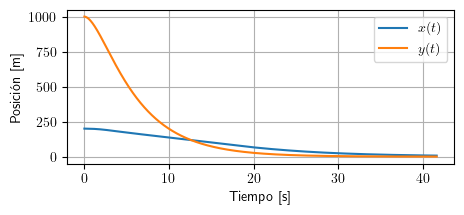

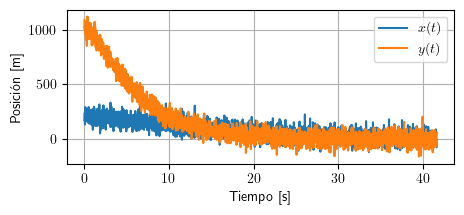

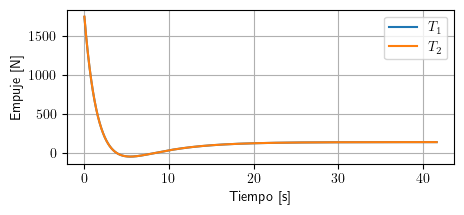

In [9]:
plt.figure(figsize=(5, 2))
plt.plot(ts, xs[:,0], label=r"$x(t)$")
plt.plot(ts, xs[:,1], label=r"$y(t)$")
plt.legend(loc='upper right')
plt.grid()
plt.xlabel(r"Tiempo [s]")
plt.ylabel(r"Posición [m]")
plt.savefig("img/sim_sinruido.svg")

plt.figure(figsize=(5, 2))
plt.plot(ts, zs[:,0], label=r"$x(t)$")
plt.plot(ts, zs[:,1], label=r"$y(t)$")
plt.legend(loc='upper right')
plt.grid()
plt.xlabel(r"Tiempo [s]")
plt.ylabel(r"Posición [m]")
plt.savefig("img/sim_conruido.svg")

plt.figure(figsize=(5, 2))
plt.plot(ts, us[:,0], label=r"$T_1$")
plt.plot(ts, us[:,1], label=r"$T_2$")
plt.legend(loc='upper right')
plt.grid()
plt.xlabel(r"Tiempo [s]")
plt.ylabel(r"Empuje [N]")
plt.savefig("img/sim_sinruido_u.svg")

In [10]:
# Simulación con ruido, control perfecto
# Condiciones iniciales del laboratorio 2
x = np.array([
	200,
	1000,
	0,
	-1,
	-5,
	0
])

# Matrices filtro de Kalman
timestep = 1/60
kf = KalmanFilter(dim_x=6, dim_z=6, dim_u=2)
# Belief
kf.x = np.array([200, 1000, 0, -1, -5, 0])
kf.P = np.diag([pos_var, pos_var, giro_var, vel_var, vel_var, giro_var])
# Input
kf.B = npB*timestep
# Proceso
kf.F = npA*timestep + np.diag([1, 1, 1, 1, 1, 1])
kf.Q = 0
# Medición
kf.H = np.array([
    [1, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0],
    [0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 1]
])
kf.R = np.diag([pos_var, pos_var, giro_var, vel_var, vel_var, giro_var])

# Arrays que almacenan el estado real, tiempo, medición y estado del filtro
xs = []
ts = []
zs = []
kfx = []
us = []

# Simulación
for i in range(2500):
	# Predicción filtro, control perfecto
	#u = np.dot(-K.gain_matrix, kf.x)
	u = np.dot(-K.gain_matrix, x)
	us.append(u + control_offset)
	kf.predict(u)
	# Avanzar simulación
	t = i * timestep
	ts.append(t)
	x = x + [xk * timestep for xk in fun(t, x, u)]
	xs.append(x)
	z = get_measurement(x)
	zs.append(z)
	# Introducir medición al filtro
	kf.update(z)
	kfx.append(kf.x)

xs = np.array(xs)
zs = np.array(zs)
kfx = np.array(kfx)
us = np.array(us)

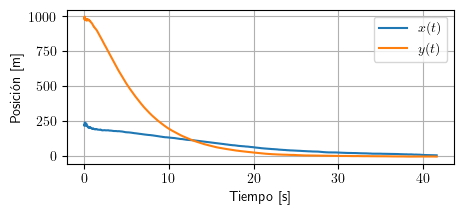

In [11]:
plt.figure(figsize=(5, 2))
plt.plot(ts, kfx[:,0], label=r"$x(t)$")
plt.plot(ts, kfx[:,1], label=r"$y(t)$")
plt.legend(loc='upper right')
plt.grid()
plt.xlabel(r"Tiempo [s]")
plt.ylabel(r"Posición [m]")
plt.savefig("img/sim_conruido_ctrlperfecto.svg")

In [12]:
# Simulación con ruido, control afectado por medición con ruido
# Condiciones iniciales del laboratorio 2
x = np.array([
	200,
	1000,
	0,
	-1,
	-5,
	0
])

# Belief
kf.x = np.array([200, 1000, 0, -1, -5, 0])
kf.P = np.diag([pos_var, pos_var, giro_var, vel_var, vel_var, giro_var])

# Arrays que almacenan el estado real, tiempo, medición y estado del filtro
xs = []
ts = []
zs = []
kfx = []
us = []

# Simulación
for i in range(2500):
	# Predicción filtro
	u = np.dot(-K.gain_matrix, kf.x)
	us.append(u + control_offset)
	kf.predict(u)
	# Avanzar simulación
	t = i * timestep
	ts.append(t)
	x = x + [xk * timestep for xk in fun(t, x, u)]
	xs.append(x)
	z = get_measurement(x)
	zs.append(z)
	# Introducir medición al filtro
	kf.update(z)
	kfx.append(kf.x)

xs = np.array(xs)
zs = np.array(zs)
kfx = np.array(kfx)
us = np.array(us)

In [13]:
plt.figure(figsize=(5, 2))
plt.plot(ts, zs[:,0], label=r"$x(t)$")
plt.plot(ts, zs[:,1], label=r"$y(t)$")
plt.legend(loc='upper right')
plt.grid()
plt.xlabel(r"Tiempo [s]")
plt.ylabel(r"Posición [m]")
plt.savefig("img/sim_conruido_zs.svg")

plt.figure(figsize=(5, 2))
plt.plot(ts, kfx[:,0], label=r"$x(t)$")
plt.plot(ts, kfx[:,1], label=r"$y(t)$")
plt.legend(loc='upper right')
plt.grid()
plt.xlabel(r"Tiempo [s]")
plt.ylabel(r"Posición [m]")
plt.savefig("img/sim_conruido_kfx.svg")

plt.figure(figsize=(5, 2))
plt.plot(ts, us[:,0], label=r"$T_1$")
plt.plot(ts, us[:,1], label=r"$T_2$")
plt.legend(loc='upper right')
plt.grid()
plt.xlabel(r"Tiempo [s]")
plt.ylabel(r"Empuje [N]")
plt.savefig("img/sim_conruido_us.svg")